In [1]:
import glob
import math
from typing import Iterable, Mapping, Any
import pickle

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import seaborn as sns
sns.set_style("whitegrid")

import malloovia

In [2]:
palette = {
        "priv-new": '#EAE4EA',
        "priv-prev": '#B7B7B7',
        "pub-dem": '#CA4F67',
        "pub-res": '#96C6E2'
}

# Workload

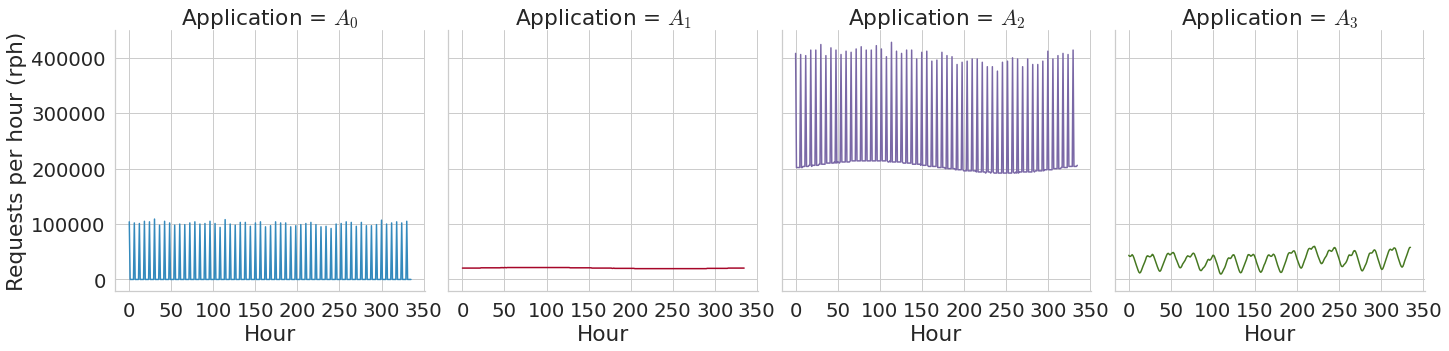

In [3]:
with sns.plotting_context("notebook", font_scale=1.8),\
     open('sols/001_sol.p', "rb") as f:
    sol = pickle.load(f)

    wl_dict = {}
    for wl in sol.problem.workloads:
        wl_dict[f'$A_{wl.app.id[-1]}$'] = wl.values[:24*14]
        
    wl_df = pd.DataFrame(wl_dict).stack().reset_index()
    wl_df.columns = ['Hour', 'Application', 'Requests per hour (rph)']
    chart = sns.relplot(data=wl_df, x='Hour', y='Requests per hour (rph)',
                        col='Application', kind='line', hue='Application', legend=False)
    chart.fig.savefig('figs/traces_wide.png', bbox_inches='tight', dpi=300)

# Allocation

In [4]:
def plot_solution_slots(solution, ax=None, xlim=None, colors=None, figsize=None, 
        linewidth=None, kind="steps", colormaps=None, legend=True,
        pos_legend=None, amazon_or_azure=True):

    # Make a copy, since we will alter the data to plot it stepwise
    df = solution.copy()
    # Clip-out unwanted xlim
    if xlim is not None:
        df=df[slice(*xlim)]
    # Remove unused Instance Classes
    df = df[df.columns[(df.fillna(0) != 0).any()]]  

    # Reorder columns: first private, then reserved, then on-demand
    # (ondemand are ordered alphabetically)
    def order(s):
        priv = "00" if "priv-prev" in s else "10"
        if "priv-new" in s:
            priv = "01"
        r = "00" if "Res" in s else "10"
        kind = 0
        if "xlarge" in s: kind+=1
        if "2xlarge" in s: kind+=1
        if "4xlarge" in s: kind+=1
        return "{}{}{}{}".format(priv, r, kind, s)
        
    df = df[sorted(df.columns, key=order)]

    # Create the colormaps
    if colors is None:
        if colormaps is None:
            colormaps = {"Azure": cm.cool, "Amazon": cm.autumn}
        colors = []
        zone_counter = {}
        for zone in colormaps.keys():
            zone_counter[zone] = [1, len([x for x in df.columns if zone in x])]
        total_classes = len(df.columns)
        c_others = 0
        for c in df.columns:
            for k in colormaps.keys():
                if k in c:
                    colors.append(colormaps[k](zone_counter[k][0]/zone_counter[k][1]))
                    zone_counter[k][0]+=1
                    break
            else:
                colors.append(cm.bone(c_others/total_classes))
                c_others+=1

    if figsize is None:
        figsize = (4,2.5)
    if linewidth is None:
        linewidth = 0.5
    if pos_legend is None:
        pos_legend = ("upper center", (0.5, -0.25))

    if ax is None:
        fig, ax = plt.subplots()

    if kind=="steps":
        # Double the data, to make a stepwise function
        aux = pd.DataFrame()
        for c in df.columns:
            y = df[c].values
            yy = np.array([y,y]).flatten("F")
            aux[c] = yy[1:]
        x = df.index
        aux["time"] = np.array([x,x]).flatten('F')[:-1]
        df=aux
        p = df.plot(x="time", ax=ax, kind="area", stacked=True, figsize=figsize, 
                    linewidth=linewidth, alpha=0.7, legend=False,
                    color=colors, ylim=(0,None))

        # Create the legend and put it outside
        if legend:
            handles, labels = p.get_legend_handles_labels()
            p.legend(reversed([mpatches.Rectangle((0, 0), 1, 1, fc=handle.get_facecolor()[0], 
                                               linewidth=handle.get_linewidth(), 
                                               alpha=handle.get_alpha())
                            for handle in handles[:len(df.columns)]]) , reversed(labels[:len(df.columns)]), 
                   loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        p = df.plot(ax=ax, kind="bar", stacked=True, figsize=figsize, 
                    linewidth=linewidth, alpha=0.7, legend=False,
                    color=colors, ylim=(0,None))
        for container in ax.containers:
            plt.setp(container, width=1)
        ticks = ax.xaxis.get_ticklocs()
        ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
        ax.xaxis.set_ticks(ticks[::5])
        ax.xaxis.set_ticklabels(ticklabels[::5])
        plt.tight_layout()
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(reversed(handles), reversed(labels), loc=pos_legend[0], bbox_to_anchor=pos_legend[1])
        
    ax.set_xlabel("Hour")
    ax.set_ylabel("# of VMs")
    return p

def allocation_info_as_dicts_expanded_in_time(
    alloc: malloovia.AllocationInfo,
    workloads: Iterable[malloovia.Workload],
    use_ids=True,
    include_timeslot=True,
    include_workloads=True,
) -> Iterable[Mapping[Any, Any]]:

    def _repr(element):
        if use_ids:
            return element.id

        return element

    memoized = {}
    for slot, t_alloc in enumerate(alloc.values):
        memoized[alloc.workload_tuples[slot]] = t_alloc

    for slot, wl in enumerate(zip(*(w.values for w in workloads))):
        t_alloc = memoized[wl]
        for app, a_alloc in enumerate(t_alloc):
            for i, ic_alloc in enumerate(a_alloc):
                result = {}
                result["instance_class"] = _repr(alloc.instance_classes[i])
                result["app"] = _repr(alloc.apps[app])
                result[alloc.units] = ic_alloc
                if include_workloads:
                    result["workload"] = wl
                if include_timeslot:
                    result["timeslot"] = slot
                yield result

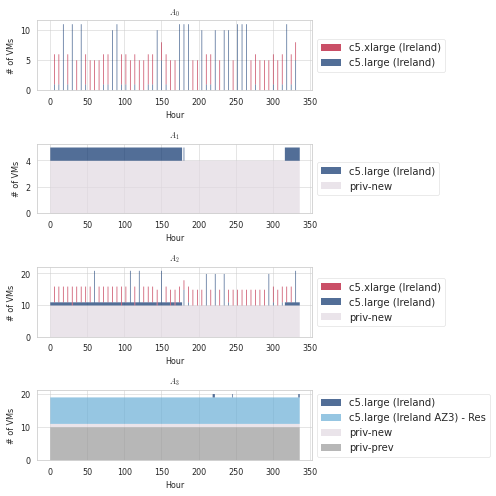

In [5]:
with open(f'sols/004_sol.p', "rb") as f:
    sol = pickle.load(f)

    dft = (pd.DataFrame(
            allocation_info_as_dicts_expanded_in_time(
                        alloc = sol.allocation,
                        workloads=sol.problem.workloads,
                        use_ids=True,
                        include_workloads=True,
                        include_timeslot=True))
            .set_index(["timeslot", "workload", "app", "instance_class"])
            .unstack()
        )

    dft_used = dft[dft.columns[(dft != 0).any()]].copy()
    dft_used.columns = [c[1] for c in dft_used.columns]

    try:
        __ = slice(None)
    except Exception:
        pass # The second time, it doesn't work

    app0_alloc  = dft_used.loc(axis=0)[(__, __, 'a0')].reset_index(drop=True)
    app1_alloc  = dft_used.loc(axis=0)[(__, __, 'a1')].reset_index(drop=True)
    app2_alloc  = dft_used.loc(axis=0)[(__, __, 'a2')].reset_index(drop=True)
    app3_alloc  = dft_used.loc(axis=0)[(__, __, 'a3')].reset_index(drop=True)
    all_apps = app0_alloc + app1_alloc + app2_alloc + app3_alloc

    improved_names = {
        'c5.2xlarge_EU (Ireland)': 'c5.2xlarge (Ireland)',
        'c5.4xlarge_EU (Ireland)': 'c5.4xlarge (Ireland)',
        'c5.large_EU (Ireland)': 'c5.large (Ireland)',
        'c5.large_EU (Ireland)_EU (Ireland)_AZ3': 'c5.large (Ireland AZ2) - Res',
        'c5.large_EU (Ireland)_EU (Ireland)_AZ2': 'c5.large (Ireland AZ3) - Res',
        'c5.xlarge_EU (Ireland)': 'c5.xlarge (Ireland)',
        'priv': 'priv-new',
        'priv_prev': 'priv-prev'
    }
        
    fig, ax = plt.subplots(4)
    colormap = {
        "priv-new": cm.twilight,
        "priv-prev": cm.Set1,
        "5.large": cm.Blues,
        "5.xlarge": cm.coolwarm,
        "5.2xlarge": cm.Reds,
        "5.4xlarge": cm.Set2,
        "Res": cm.winter
    }

    # Zoom on some part of the allocation
    zoom = slice(0, 24*7*2) 
    for i, a in enumerate([app0_alloc, app1_alloc, app2_alloc, app3_alloc]):
        improved_col_names = [improved_names[c] for c in a.columns]
        a.columns = improved_col_names
        
        plot_solution_slots(a[zoom], legend=True, ax=ax[i], colormaps=colormap,
                            figsize=(7,7), kind="steps", linewidth=0)
        ax[i].set_title(f"$A_{i}$")

        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] +
                      ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            item.set_fontsize(8)
            
        fig.tight_layout()

    fig.savefig('figs/alloc.png', bbox_inches='tight', dpi=300)

# Solution summary

In [6]:
sol_files = [f'{i+1:03}_sol.p' for i in range(4)]

sol_summary = {}
for sol_file in sol_files:
    with open(f'sols/{sol_file}', "rb") as f:
        sol = pickle.load(f)

    ics = set(ic.name for ic in sol.problem.instance_classes)
    priv_new = [ic for ic in sol.problem.instance_classes if ic.id == "priv"]
    priv_pre = [ic for ic in sol.problem.instance_classes if ic.id == "priv_prev"]

    priv_new_indexes = [i for i,ic in enumerate(sol.allocation.instance_classes) if ic.id == "priv"]
    priv_prev_indexes = [i for i,ic in enumerate(sol.allocation.instance_classes) if ic.id == "priv_prev"]
    pub_res_indexes = [i for i,ic in enumerate(sol.allocation.instance_classes) if ic.is_reserved and "priv" not in ic.id]
    
    np_alloc = np.array(sol.allocation.values)
    num_vms_per_wl = np_alloc.sum(axis=1)
    max_vms = num_vms_per_wl.max(axis=0) # List where each value is the max of VMs of ic index i

    pub_res = np.take(max_vms, pub_res_indexes).sum()
    pub_dem = np.delete(max_vms, priv_new_indexes+priv_prev_indexes+pub_res_indexes).sum()
    
    priv_lim = 0
    if priv_new:
        priv_lim = priv_new[0].max_vms
    
    exp_summary = {
        'priv-lim': priv_lim,
        'priv-new': np.take(max_vms, priv_new_indexes).sum(),
        'priv-prev': np.take(max_vms, priv_prev_indexes).sum(),
        'pub-dem': pub_dem,
        'pub-res': pub_res,
        'cost/year (\$)': sol.solving_stats.optimal_cost
    }
    
    exp = sol_file[2:3]
    sol_summary[exp] = exp_summary

sol_df = pd.DataFrame(sol_summary).T
sol_df.index.name = 'Scenario'
print(sol_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  priv-lim &  priv-new &  priv-prev &  pub-dem &  pub-res &  cost/year (\textbackslash \$) \\
Scenario &           &           &            &          &          &                 \\
\midrule
1        &     100.0 &      63.0 &        0.0 &     12.0 &      0.0 &       5732.3040 \\
2        &      25.0 &      25.0 &        0.0 &     39.0 &      8.0 &      11894.3200 \\
3        &     100.0 &      54.0 &       10.0 &     10.0 &      0.0 &       4835.2236 \\
4        &      15.0 &      15.0 &       10.0 &     38.0 &      8.0 &      11018.4076 \\
\bottomrule
\end{tabular}



# Plot response time distributions

In [7]:
def response_time_dist(filename, exp, workload):
    reqs = pd.read_csv(filename, dtype={
        'req':'int',
        'creation': 'float',
        'start': 'float',
        'end': 'float',
        'app': 'category',
        'vm': 'category',
        'ic': 'category',
        'lost': 'bool',
    })

    reqs['resp_time'] = reqs.end-reqs.creation

    stats_df = reqs.groupby('resp_time')['resp_time'].agg('count').pipe(pd.DataFrame).rename(
        columns = {'resp_time': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    return stats_df

In [8]:
exps = [f'{i+1:03}' for i in range(4)]
types = ['uniform', 'smooth']

rt_dists_df = pd.DataFrame()
for i, exp in enumerate(exps):
    for j, t in enumerate(types):
        rt_dist = response_time_dist(f'res_sim/{exp}_{t}_reqs.csv', exp, t)
        rt_dist['Scenario'] = exp
        rt_dist['Workload'] = t
        rt_dists_df = rt_dists_df.append(rt_dist)

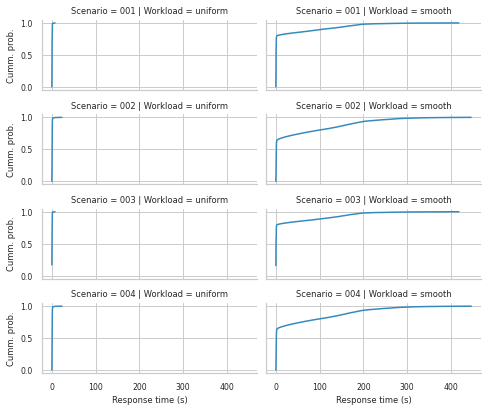

In [9]:
with sns.plotting_context("notebook", font_scale=0.7):
    g = sns.relplot(data=rt_dists_df, x='resp_time', y='cdf', col='Workload', row='Scenario', kind='line',
            aspect=2.4,
            height=1.4,
           )
    g.set_axis_labels('Response time (s)', 'Cumm. prob.')
    g.fig.savefig('figs/cdf_resp_times.png', bbox_inches='tight', dpi=300)

# Plot number of requests

In [10]:
req_files = glob.glob('res_sim/0*[smooth|uniform]_reqs.csv')
df_req = pd.DataFrame()
for f in req_files:
    df = pd.read_csv(f,
                     usecols=['creation', 'start', 'end', 'app', 'ic'],
                     dtype={
                        'creation': 'float',
                        'start': 'float',
                        'end': 'float',
                        'app': 'category',
                        'ic': 'category',
                     },
                    )
 
    scenario = f[10:11]
    workload = f.split('_')[2].split('.')[0]

    df['Scenario'] = scenario
    df['Workload'] = workload
    
    df_req = df_req.append(df)

In [11]:
# Categories are lost on the merge. Get them back
df_req.ic = df_req.ic.astype('category')
df_req.Scenario = df_req.Scenario.astype('category')
df_req.Workload = df_req.Workload.astype('category')

In [12]:
secs = math.ceil(df_req.end.max())
hours = int(secs/3600)
print(f"Lenght of the trace: {secs} ({hours} h)")

Lenght of the trace: 604800 (168 h)


In [13]:
df_req['resp_time'] = df_req.end - df_req.creation

In [14]:
df_req_gr_ic = df_req.groupby(['Scenario', 'Workload', 'ic']).resp_time.count().copy().reset_index().sort_values(by='ic')
df_req_gr_ic.rename(columns={'resp_time': 'req_count'}, inplace=True)

In [15]:
# Add type of IC and of cloud

def ic_cat(row):
    name = ''
    if row.ic == 'priv':
        return 'priv-new'
    
    if row.ic == 'priv_prev':
        return 'priv-prev'
    
    if 'AZ' in row.ic:
        return 'pub-res'
    
    return 'pub-dem'

df_req_gr_ic['ic_cat'] = df_req_gr_ic.apply(lambda row: ic_cat(row), axis=1)
df_req_gr_ic['cloud_type'] = df_req_gr_ic.apply(lambda row: 'priv' if 'priv' in row.ic_cat else 'pub', axis=1)

In [16]:
df_req_gr_ic_cat = df_req_gr_ic.groupby(['Scenario', 'Workload', 'ic_cat']).sum().copy().reset_index().sort_values(by='ic_cat')

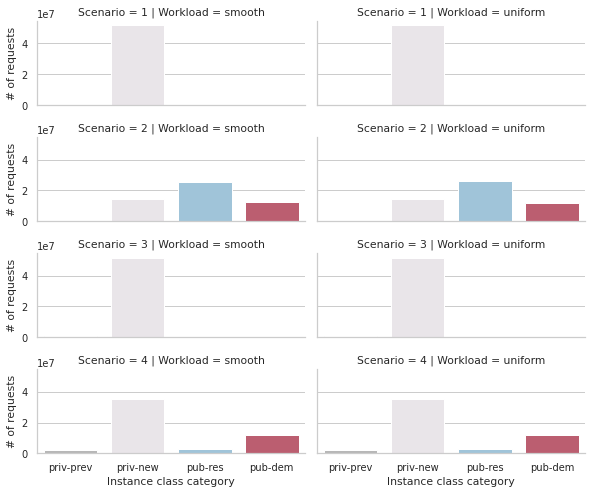

In [17]:
with sns.plotting_context("notebook", font_scale=0.9):
    chart = sns.catplot(data=df_req_gr_ic_cat, x='ic_cat', y='req_count', row='Scenario', col='Workload', kind='bar',
                        legend='full', 
                        aspect=2.4,
                        height=1.7,
                        palette=palette,
                        order=['priv-prev', 'priv-new', 'pub-res', 'pub-dem']
               )
    chart.set_axis_labels('Instance class category', '# of requests')
    chart.savefig('figs/reqs_cat.png', bbox_inches='tight', dpi=300)

# Average response time per application

In [18]:
df_app_resp_gr = df_req.groupby(['Scenario', 'Workload', 'app']).resp_time.mean().copy().reset_index().sort_values(by='app')

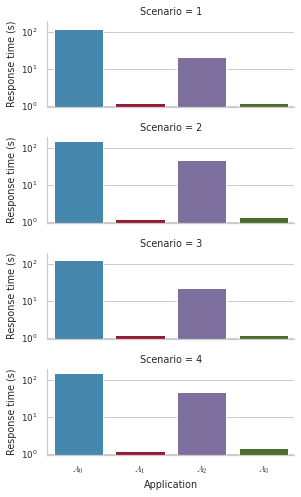

In [19]:
with sns.plotting_context("notebook", font_scale=0.8):
    df_app_resp_gr['App'] = '$A_' + df_app_resp_gr.app.str[1] + '$'
    chart = sns.catplot(data=df_app_resp_gr[df_app_resp_gr.Workload=='smooth'], x='App', y='resp_time',
                row='Scenario', kind='bar', legend='full',
                aspect=2.4,
                height=1.7,
                #hue='demand_factor', style='demand_factor', markers=True, col='apps', col_wrap=3
               )
    chart.set_axis_labels('Application', 'Response time (s)')
    chart.axes[0][0].set_yscale('log')
    chart.fig.savefig('figs/resp_time_app.png', bbox_inches='tight', dpi=300)

# Analysis of high response times

In [20]:
two_wl = df_req[df_req.Scenario=='2'].groupby(['Workload', 'app', 'creation']).resp_time.count().reset_index()
two_wl.rename(columns={'resp_time': 'req_count'}, inplace=True)

In [21]:
resp_time_two_wl = df_req[df_req.Scenario=='2'].groupby(['Workload', 'app', 'creation']).resp_time.mean().reset_index()

In [22]:
# Response times compared to workloads in the first two hours of App 3
h0 = 0
h1 = 27

start_h0 = 3600*h0
end_h0 = start_h0 + 3600

start_h1= 3600*h1
end_h1 = start_h1 + 3600

r_data_h0 = resp_time_two_wl[(resp_time_two_wl.creation>=start_h0) & (resp_time_two_wl.creation<end_h0) & (resp_time_two_wl.app=='a2')].copy()
r_data_h0['hour'] = h0

r_data_h1 = resp_time_two_wl[(resp_time_two_wl.creation>=start_h1) & (resp_time_two_wl.creation<end_h1) & (resp_time_two_wl.app=='a2')].copy()
r_data_h1['hour'] = h1

r_data = pd.concat([r_data_h0, r_data_h1])

w_data_h0 = two_wl[(two_wl.creation>=start_h0) & (two_wl.creation<end_h0) & (two_wl.app=='a2')].copy()
w_data_h0['hour'] = h0

w_data_h1 = two_wl[(two_wl.creation>=start_h1) & (two_wl.creation<end_h1) & (two_wl.app=='a2')].copy()
w_data_h1['hour'] = h1

w_data = pd.concat([w_data_h0, w_data_h1])

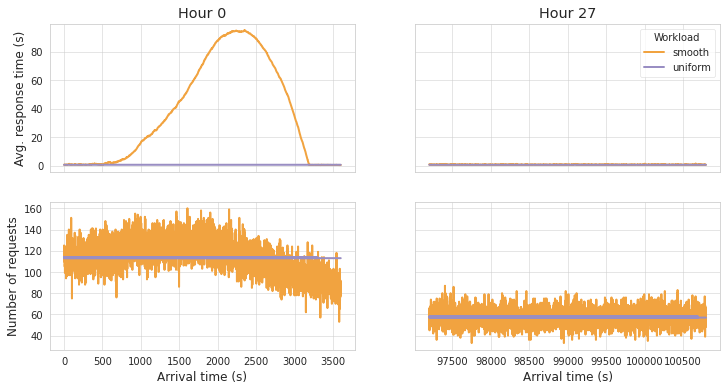

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex='col', sharey='row')

palette = [ '#f1a340', '#998ec3']

g = sns.lineplot(data=r_data_h0, x='creation', y='resp_time', hue='Workload', ax=axes[0][0],
             hue_order=['smooth', 'uniform'], palette=palette)
g.get_legend().remove()
g.set(xlabel='Arrival time (s)', ylabel='Avg. response time (s)')

g = sns.lineplot(data=r_data_h1, x='creation', y='resp_time', hue='Workload', ax=axes[0][1],
            hue_order=['smooth', 'uniform'], palette=palette)
#g.get_legend().remove()
g.set(xlabel='Arrival time (s)', ylabel='Avg. resp. time (s)')

g = sns.lineplot(data=w_data_h0, x='creation', y='req_count', hue='Workload', ax=axes[1][0],
             hue_order=['smooth', 'uniform'], palette=palette)
g.get_legend().remove()
g.set(xlabel='Arrival time (s)', ylabel='Number of requests')

g = sns.lineplot(data=w_data_h1, x='creation', y='req_count', hue='Workload', ax=axes[1][1],
            hue_order=['smooth', 'uniform'], palette=palette)
g.set(xlabel='Arrival time (s)', ylabel='Number of requests')
g.get_legend().remove()

axes[0][0].set_title(f'Hour {h0}')
axes[0][1].set_title(f'Hour {h1}')

fig.savefig('figs/comparison.png', bbox_inches='tight', dpi=300)